In [1]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens

In [132]:
def create_dataset(dataset, true_price, look_back = 1):
      
    # MinMax
    #min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    #dataset = min_max_scaler.fit_transform(dataset)
    
    # Standarised
    sc = preprocessing.StandardScaler()
    dataset = sc.fit_transform(dataset)
    
    
    lookback = look_back
    datax = []
    datay = []
    for i,v in enumerate(dataset):
        if i > lookback:
            datax.append([dataset[i-j] for j in range(lookback, 0, -1)])
            datay.append(true_price[i])    

    datax = np.array(datax)
    datay = np.array(datay)
    
    mean = datay.mean(axis=0)
    datay -= mean
    std = datay.std(axis=0)
    datay /= std
    


    
    
    
    
    # Normalize
    #datax = preprocessing.normalize(datax)
    #datay = preprocessing.normalize(datay)
    
    # reshape input to be [samples, time steps, features]
    datax = np.reshape(datax, (datax.shape[0], lookback, 1))
    
    return datax, datay

In [3]:
def make_ready(filer):
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = cleanup.clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_5_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma5_derivert'] = [stock.open_5_sma[i] / stock.open_5_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_5_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        break # må tas bort ettervært
    
    return stock

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [4]:
cleanup = rens()

In [5]:
filer = list(map(add_data, os.listdir('data/')))[5:6] # 60 første er lagd til å bygge modell
data = make_ready(filer)
data

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_5_sma,sma8-16,sma30_derivert,sma5_derivert,derivert
0,9:0,159.85,159.85,159.85,159.85,28547,28547,NaN,NaN,NaN,...,159.850000,0.000000,0.000000,0.000000,159.850000,159.8500,0.000000,1.000000,1.000000,1.000000
1,9:1,160.00,160.00,160.00,160.00,7714,7714,159.85,0.15,inf,...,159.925000,0.003365,0.001870,0.001496,159.925000,159.9250,0.000000,1.000000,1.000000,1.000000
2,9:2,160.00,160.00,160.00,160.00,4670,4670,160.00,0.00,inf,...,159.950000,0.004288,0.002861,0.001427,159.950000,159.9500,0.000000,1.000156,1.000156,1.000000
3,9:3,159.90,159.90,159.90,159.90,1870,1870,160.00,-0.10,1.353750,...,159.937500,0.000992,0.002228,-0.001236,159.937500,159.9375,0.000000,0.999922,0.999922,0.999375
4,9:4,161.00,161.00,161.00,161.00,1756,1756,159.90,1.10,12.932697,...,160.150000,0.042952,0.014342,0.028610,160.150000,160.1500,0.000000,1.001329,1.001329,1.006879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,16:16,168.40,168.40,168.40,168.40,10411,10411,167.90,0.50,1.490411,...,167.740625,0.090262,0.047243,0.043020,167.701667,167.8100,-0.059375,1.000258,1.001492,1.002978
431,16:17,168.60,168.60,168.60,168.60,5654,5654,168.40,0.20,1.619057,...,167.806250,0.148872,0.067569,0.081304,167.738333,168.0600,-0.012500,1.000219,1.001490,1.001188
432,16:18,168.90,168.90,168.90,168.90,13257,13257,168.60,0.30,1.822181,...,167.881250,0.217027,0.097460,0.119566,167.790000,168.3400,0.081250,1.000308,1.001666,1.001779
433,16:19,169.20,169.20,169.20,169.20,11841,11841,168.90,0.30,2.035996,...,167.962500,0.291882,0.136345,0.155538,167.848333,168.6000,0.256250,1.000348,1.001544,1.001776


In [133]:
datax, datay = create_dataset(data[['sma30_derivert']], data.sma30_derivert, look_back=2)

In [134]:
datay

array([-7.97628846e-01,  5.10071258e+00,  1.49354614e+00, -1.31107930e+00,
       -1.75525731e+00, -1.17904162e+00,  5.33815113e-01,  7.08103944e-01,
        1.82008342e+00,  1.56731674e+00,  2.11580364e+00,  1.24707486e+00,
        4.60493757e-01,  9.65255299e-01,  7.32839897e-01, -1.21429918e-02,
       -9.71230386e-01, -1.29634902e+00, -1.22137152e+00, -3.04869627e-01,
       -1.13441676e+00, -6.11392201e-01, -8.01364508e-01, -7.76840829e-01,
       -5.21780990e-01, -1.05850561e+00, -8.45226586e-01,  9.59741120e-02,
       -2.95855050e-01, -1.20991414e+00, -8.18239095e-01, -1.81963234e+00,
       -1.34099936e+00, -9.49134522e-01, -2.95704891e-01, -2.95712133e-01,
       -1.07983547e+00, -1.25419757e+00, -1.12361480e+00, -1.21088330e+00,
       -1.38537821e+00, -7.31570461e-01, -2.08348010e-01, -2.08364333e-01,
        1.40401668e-01,  5.32635826e-01,  1.49117864e+00,  1.70806499e+00,
        1.27155383e+00,  6.18031457e-01,  1.18336183e+00,  1.09572710e+00,
        1.48642016e+00,  

In [140]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(input_dim=datax.shape[2], units=64, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, None, 64)          16896     
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [141]:
history = model.fit(datax, datay, epochs=300, batch_size=64, validation_split=0.2,
         callbacks= [keras.callbacks.EarlyStopping(
                                    monitor='val_loss', patience=10, restore_best_weights=True)])

Train on 345 samples, validate on 87 samples
Epoch 1/300
345/345 [==============================] - 10s 28ms/sample - loss: 1.1253 - val_loss: 0.2744
Epoch 2/300
345/345 [==============================] - 0s 272us/sample - loss: 1.0369 - val_loss: 0.2574
Epoch 3/300
345/345 [==============================] - 0s 321us/sample - loss: 0.9296 - val_loss: 0.2344
Epoch 4/300
345/345 [==============================] - 0s 330us/sample - loss: 0.8017 - val_loss: 0.2113
Epoch 5/300
345/345 [==============================] - 0s 359us/sample - loss: 0.6453 - val_loss: 0.1860
Epoch 6/300
345/345 [==============================] - 0s 400us/sample - loss: 0.4731 - val_loss: 0.1543
Epoch 7/300
345/345 [==============================] - 0s 243us/sample - loss: 0.4091 - val_loss: 0.1233
Epoch 8/300
345/345 [==============================] - 0s 304us/sample - loss: 0.3892 - val_loss: 0.1097
Epoch 9/300
345/345 [==============================] - 0s 353us/sample - loss: 0.3815 - val_loss: 0.1135
Epoch 10/3

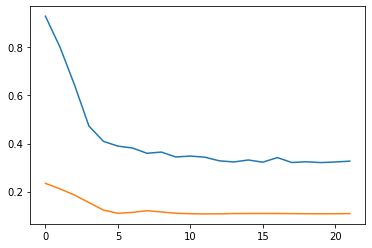

In [143]:
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])

In [144]:
predict = model.predict(datax)

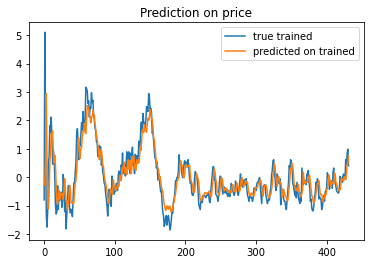

In [145]:
plt.plot(datay, label='true trained')
plt.plot(predict, label='predicted on trained')
plt.legend()
plt.title('Prediction on price')
#plt.savefig('images/RNN_on_price')
plt.show()


In [373]:
predict

array([[165.44948],
       [165.44948],
       [165.44948],
       [165.44945],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44948],
       [165.44948],
       [165.44946],
       [165.44946],
       [165.44948],
       [165.44948],
       [165.44948],
       [165.44948],
       [165.44948],
       [165.44946],
       [165.44948],
       [165.44948],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],


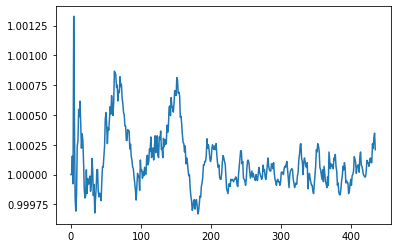

In [68]:
plt.plot(data.sma30_derivert)
#plt.plot(data.sma5_derivert)